# Binomial/Bernoulli + Logistic (Normal)


In [1]:
import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, Predictive
import jax 
import jax.random as random 
import jax.numpy as jnp 

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns; 
#sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

In [2]:
rngkey = random.PRNGKey(0)
rngkey, subkey = jax.random.split(rngkey)
rngkey

array([4146024105,  967050713], dtype=uint32)

## Logistic (or sigmoid) function

$$
    \mathrm{logistic}(x) = \mathrm{sigmoid}(x) = \mathrm{expit}(x) = \frac{1}{1 + e^{-x}}
$$

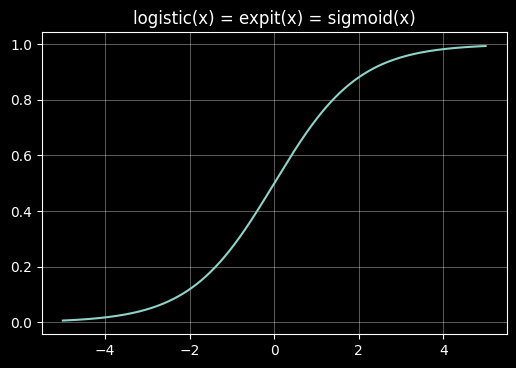

In [3]:
x = jnp.linspace(-5, 5, 1000)
p = jax.scipy.special.expit(x)

plt.plot(x, p);
plt.grid(); plt.title('logistic(x) = expit(x) = sigmoid(x)');

Inverse of expit is logit:

$$
    \mathrm{logit}(p) = \log\frac{p}{1-p} = x
$$

(-4.0, 4.0)

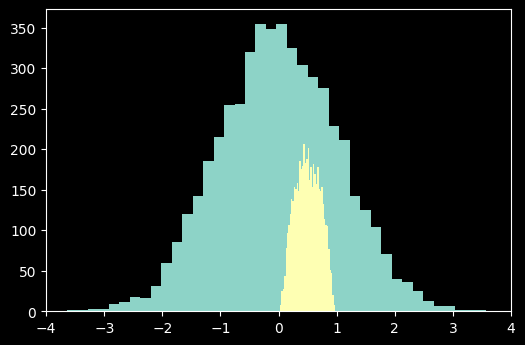

In [4]:
xr = stats.norm(0, 1).rvs(5000)
pr = jax.scipy.special.expit(xr)

plt.hist(xr, bins=40);
plt.hist(pr, bins=40);
plt.xlim([-4, 4])

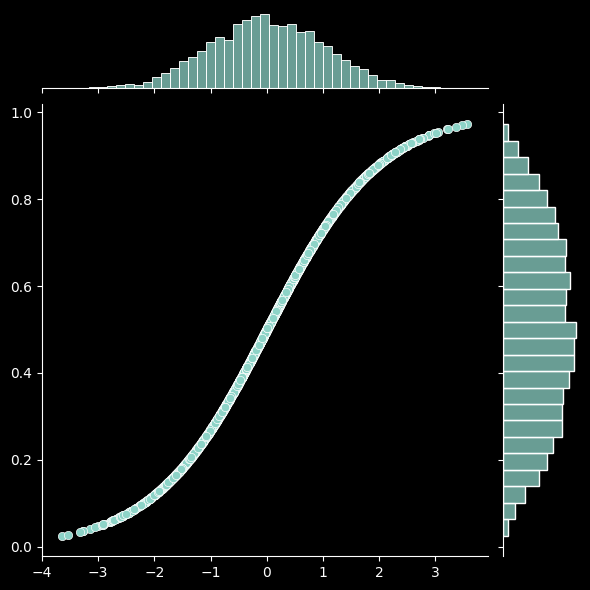

In [5]:
sns.jointplot(x=xr, y=pr);

(-4.0, 4.0)

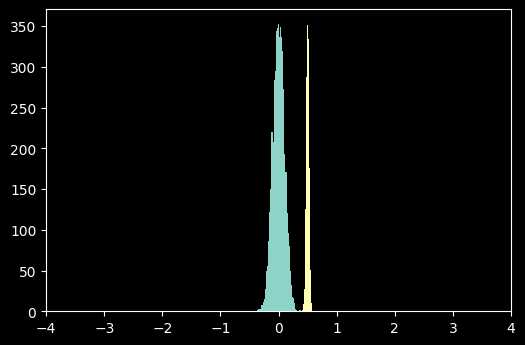

In [6]:
xr = stats.norm(0, 1/10).rvs(5000)
pr = jax.scipy.special.expit(xr)

plt.hist(xr, bins=40);
plt.hist(pr, bins=40);
plt.xlim([-4, 4])

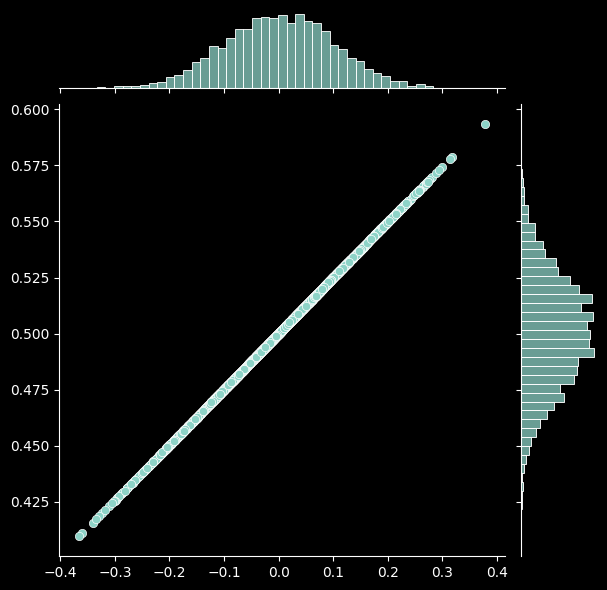

In [7]:
sns.jointplot(x=xr, y=pr);

In [8]:
xr = stats.norm(0, 1.55).rvs(5000)
pr = jax.scipy.special.expit(xr)

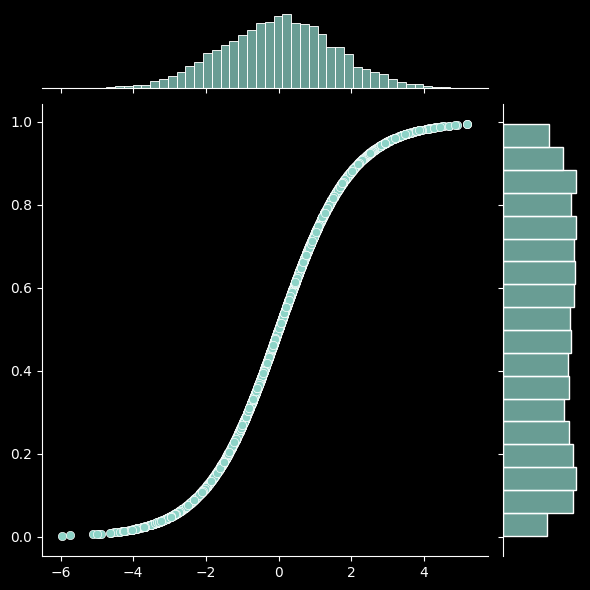

In [9]:
sns.jointplot(x=xr, y=pr);

In [10]:
xr = stats.norm(0, 4).rvs(5000)
pr = jax.scipy.special.expit(xr)

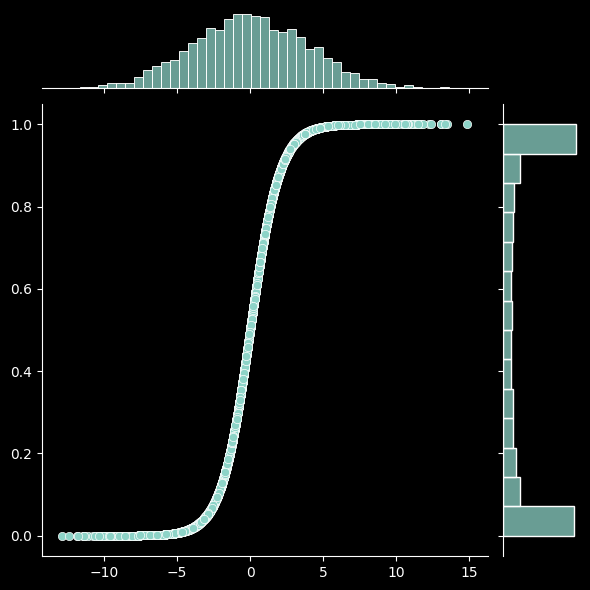

In [11]:
sns.jointplot(x=xr, y=pr);

## With Binomial Likelihood

In [12]:
def model(mu, sigma, N, z=None):
    x = numpyro.sample('x', dist.Normal(loc=mu, scale=sigma))
    theta = jax.scipy.special.expit(x)
    numpyro.deterministic('theta', theta)
    obs = numpyro.sample('obs', dist.Binomial(total_count=N, probs=theta), obs=z)

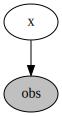

In [13]:
numpyro.render_model(model, model_args=(0, 1/5., 20, 17))

## Run MCMC inference

In [14]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)

#
mu, sigma = 0, 1./5  # prior model
N, z = 20, 17   # observation from binomial 
#
mcmc.run(rngkey, mu=mu, sigma=sigma, N=N, z=z)
mcmc.print_summary(exclude_deterministic=False, prob=.8)

sample: 100%|██████████| 16000/16000 [00:13<00:00, 1151.39it/s, 1 steps of size 8.34e-01. acc. prob=0.94]



                mean       std    median     10.0%     90.0%     n_eff     r_hat
     theta      0.56      0.04      0.56      0.50      0.61   6291.13      1.00
         x      0.24      0.18      0.24     -0.00      0.46   6278.30      1.00

Number of divergences: 0


In [19]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)

#
mu, sigma = 0, 1.6  # prior model
N, z = 200, 170   # observation from binomial 
#
mcmc.run(rngkey, mu=mu, sigma=sigma, N=N, z=z)
mcmc.print_summary(exclude_deterministic=False, prob=.8)

sample: 100%|██████████| 16000/16000 [00:14<00:00, 1127.91it/s, 1 steps of size 9.00e-01. acc. prob=0.94]


                mean       std    median     10.0%     90.0%     n_eff     r_hat
     theta      0.85      0.02      0.85      0.82      0.88   5800.32      1.00
         x      1.72      0.19      1.72      1.47      1.97   5679.14      1.00

Number of divergences: 0


In [15]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)

#
mu, sigma = 0, 1./5  # prior model
N, z = 200, 170   # observation from binomial 
#
mcmc.run(rngkey, mu=mu, sigma=sigma, N=N, z=z)
mcmc.print_summary(exclude_deterministic=False, prob=.8)

sample: 100%|██████████| 16000/16000 [00:13<00:00, 1156.75it/s, 1 steps of size 8.50e-01. acc. prob=0.94]


                mean       std    median     10.0%     90.0%     n_eff     r_hat
     theta      0.73      0.02      0.73      0.70      0.76   6457.30      1.00
         x      0.98      0.12      0.98      0.82      1.14   6427.86      1.00

Number of divergences: 0


In [20]:
samples = mcmc.get_samples()
samples

{'theta': DeviceArray([0.84974706, 0.8463481 , 0.86772895, ..., 0.8082832 ,
              0.8792408 , 0.8797392 ], dtype=float32),
 'x': DeviceArray([1.7326187, 1.7062413, 1.8810263, ..., 1.4388933, 1.9852608,
              1.9899629], dtype=float32)}

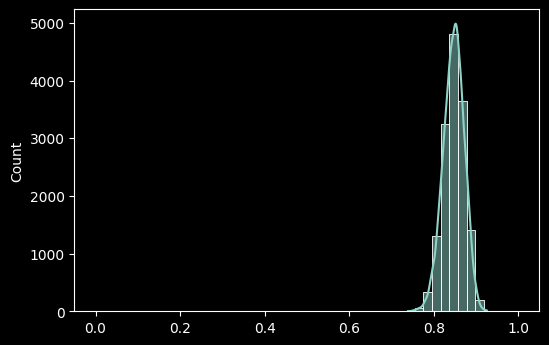

In [21]:
x = np.linspace(0, 1, 50)
sns.histplot(samples['theta'], kde=True, bins=x, );

In [17]:
# HDI: High Density Interval
s = samples['theta'].sort()
hdi_prob = .94
p = (1 - hdi_prob)/2
low_index, high_index = int(s.size * p), int(s.size*(1-p))
hdi = (s[low_index].item(), s[high_index].item())
print(f'hdi: [{hdi[0]:.3f}, {hdi[1]:.3f}]')

hdi: [0.475, 0.641]


Mode of the Posterior can be obtained with 
- KDE 
- a peak finding numerical computation.
- No closed form solution.

In [18]:
# Mode/Peak of the density approximation
import scipy 
kde = scipy.stats.gaussian_kde(s)  # density function approximation
x = np.linspace(0, 1, 1200)
pdfx = kde.evaluate(x) # function values at x
max_index = pdfx.argmax()
print(f'The KDE mode is at     {x[max_index]:.3f}')

The KDE mode is at     0.561


hdi:  (0.4753970801830292, 0.6408981084823608)


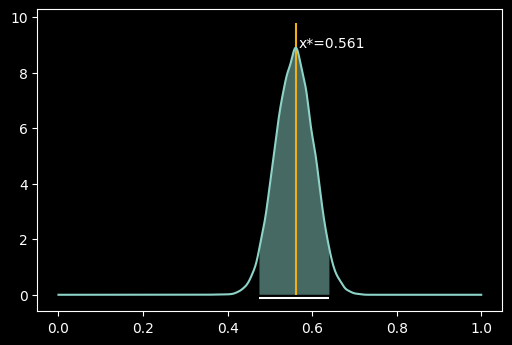

In [19]:
plt.plot(x, pdfx);
plt.vlines(x=x[max_index], ymin=0, ymax=pdfx[max_index]*1.1, colors='#f1af11');
plt.text(x=x[max_index]*1.01, y=pdfx[max_index], s=f'x*={x[max_index]:.3}');
#
plt.hlines(y=-.1, xmin=s[low_index], xmax=s[high_index])
pdfs = kde.evaluate(s)
plt.fill_between(s[low_index:high_index+1], pdfs[low_index:high_index+1], alpha=.5);
#
print('hdi: ', hdi)

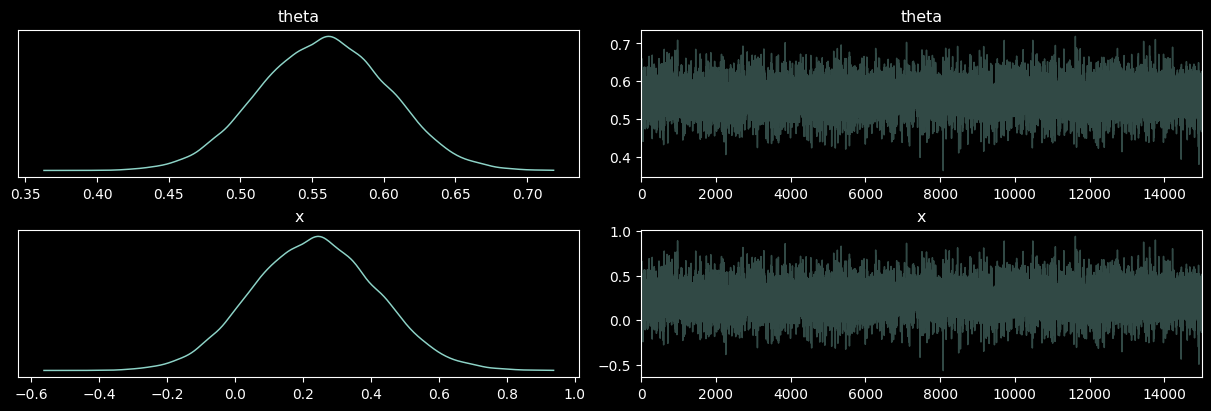

In [20]:
import arviz
arviz.plot_trace(samples);

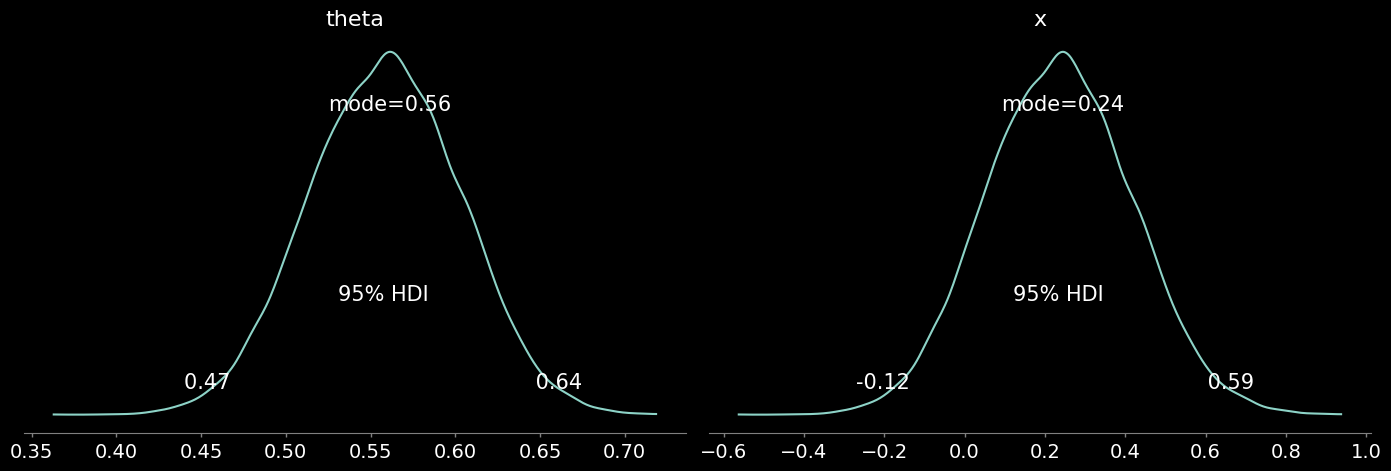

In [21]:
arviz.plot_posterior(samples, point_estimate='mode', bins=x, hdi_prob=.95);

## Posterior Prediction

In [22]:
s1 = samples['theta'][100]  # get a sample of parameter theta
y = stats.binom(n=N, p=s1).rvs(1)  # sample an observation
print('predictive obs: ', y, 'with theta: ', s1)

predictive obs:  [9] with theta:  0.51640666


In [23]:
# we may generate many predictive samples
y = stats.binom(n=N, p=s1).rvs(10000)

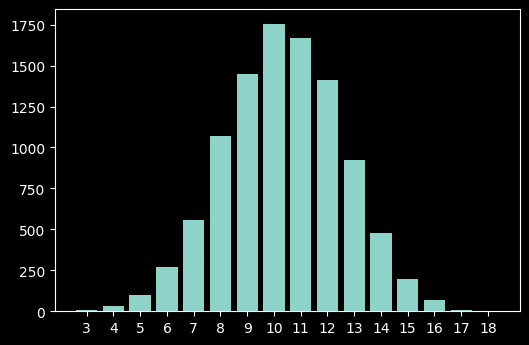

In [24]:
obs, count = np.unique(y, return_counts=True)
plt.bar(obs, count)
plt.xticks(obs);

### Posterior Predictive Check

Here we generate one obs sample for each of the posterior parametr samples

In [25]:
ypost = stats.binom(n=N, p=samples['theta']).rvs()

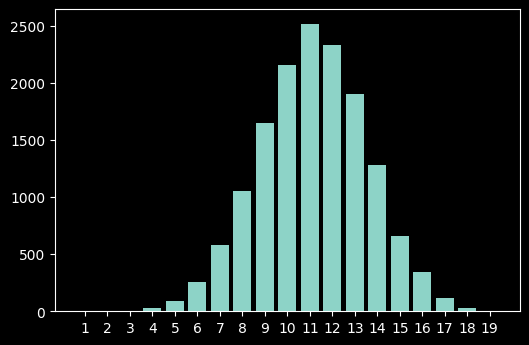

In [26]:
obs, count = np.unique(ypost, return_counts=True)
plt.bar(obs, count)
plt.xticks(obs);

- The observation z could have been 10 or 11 or even 6 instead of 17, the actual obs, according to this posterior predictive observation distribution.

### numpyro.infer.Predictive

In [27]:
# define a predictor
predictive = numpyro.infer.Predictive(model, posterior_samples=samples)

In [28]:
# run the predictor, each run will yield a different result
rngkey, subkey = jax.random.split(rngkey)
pred = predictive(rngkey, 100, 100, 20)

In [29]:
pred

{'obs': DeviceArray([ 9,  9,  9, ..., 14,  8, 13], dtype=int32),
 'theta': DeviceArray([0.56478   , 0.5584213 , 0.58723354, ..., 0.48500344,
              0.6255625 , 0.6230757 ], dtype=float32)}

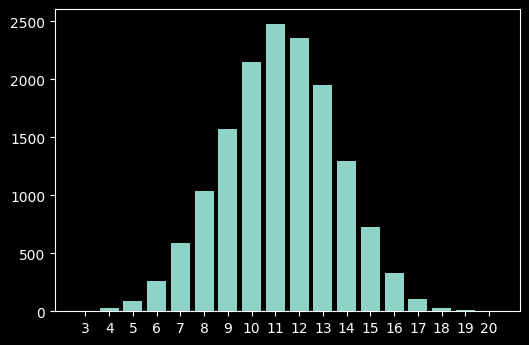

In [30]:
obs, count = np.unique(pred['obs'], return_counts=True)
plt.bar(obs, count)
plt.xticks(obs);

## Prior Predictive Check

### Direct Sampling

In [31]:
ns = 3000
x = stats.norm(mu, sigma).rvs(ns)
theta = 1. / (1. + np.exp(-x))
obs = stats.binom(n=N, p=theta).rvs()
theta.shape, obs.shape

((3000,), (3000,))

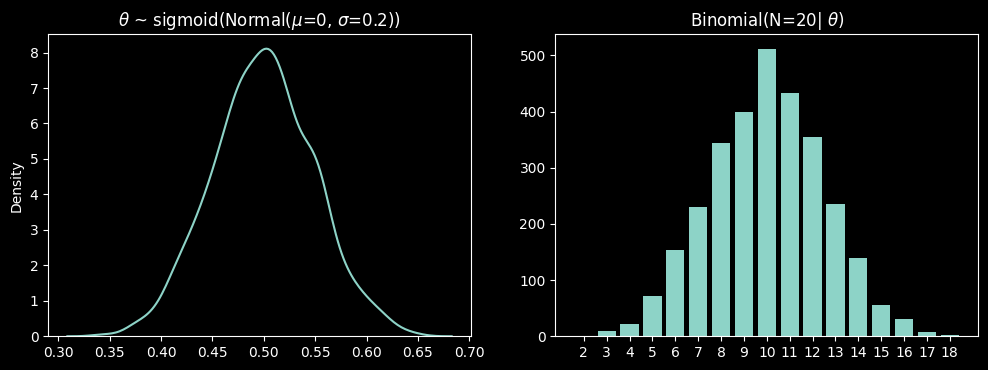

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
#
#sns.histplot(theta, bins=40, kde=True, ax=ax1);
sns.kdeplot(theta, ax=ax1);  # kde should look very same in this case
ax1.set(title=f'$\\theta$ ~ sigmoid(Normal($\\mu$={mu}, $\\sigma$={sigma}))')
#
uniq, count = np.unique(obs, return_counts=True)
ax2.bar(uniq, count)
ax2.set(xticks=uniq, title=f'Binomial(N={N}| $\\theta$)');

### numpyro.infer.Predictive

In [33]:
# define, but with model only
predictive = numpyro.infer.Predictive(model, num_samples=2999)

In [34]:
# run the predictor, each run will yield a different result
rngkey, subkey = jax.random.split(rngkey)
pred = predictive(rngkey, mu, sigma, N)

In [35]:
pred

{'obs': DeviceArray([12, 10, 12, ..., 11, 10,  6], dtype=int32),
 'theta': DeviceArray([0.4929673 , 0.48486257, 0.499741  , ..., 0.5915456 ,
              0.53072923, 0.57635653], dtype=float32),
 'x': DeviceArray([-0.02813243, -0.06056827, -0.00103605, ...,  0.37035844,
               0.1230721 ,  0.3078344 ], dtype=float32)}

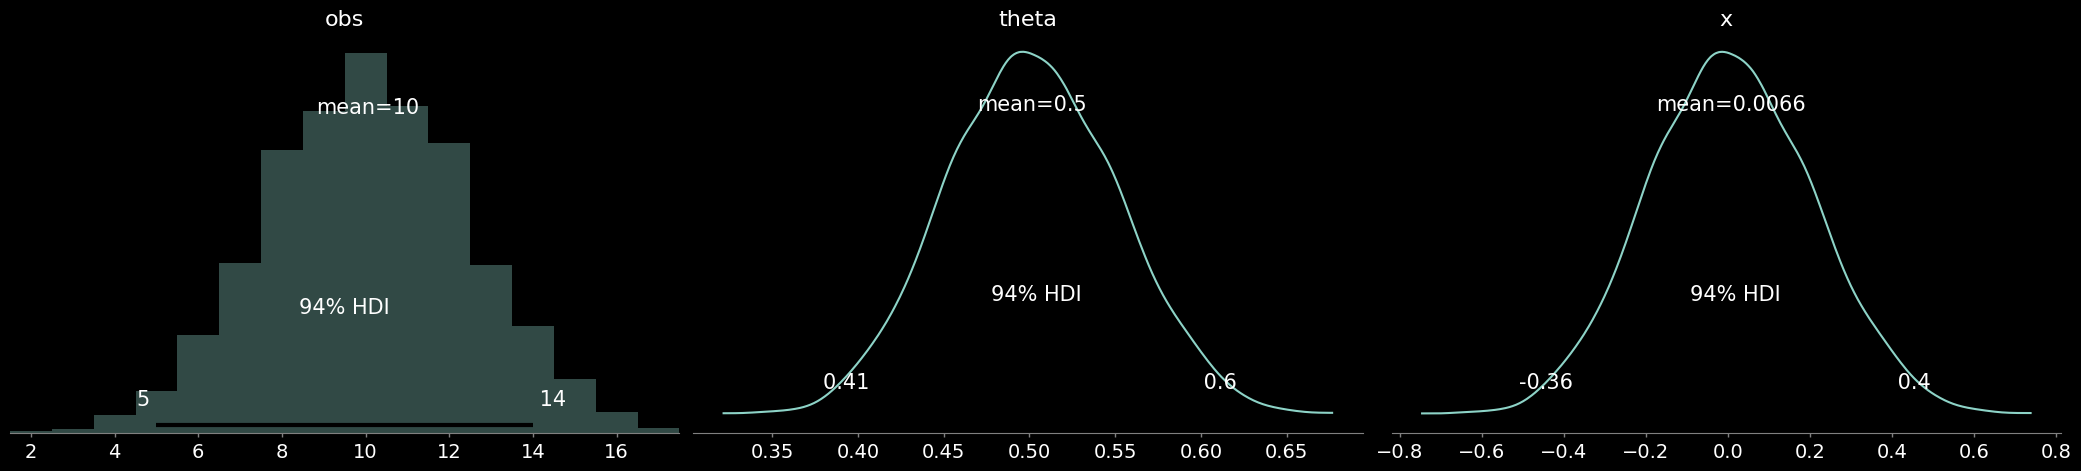

In [36]:
import arviz
arviz.plot_posterior(pred);  #

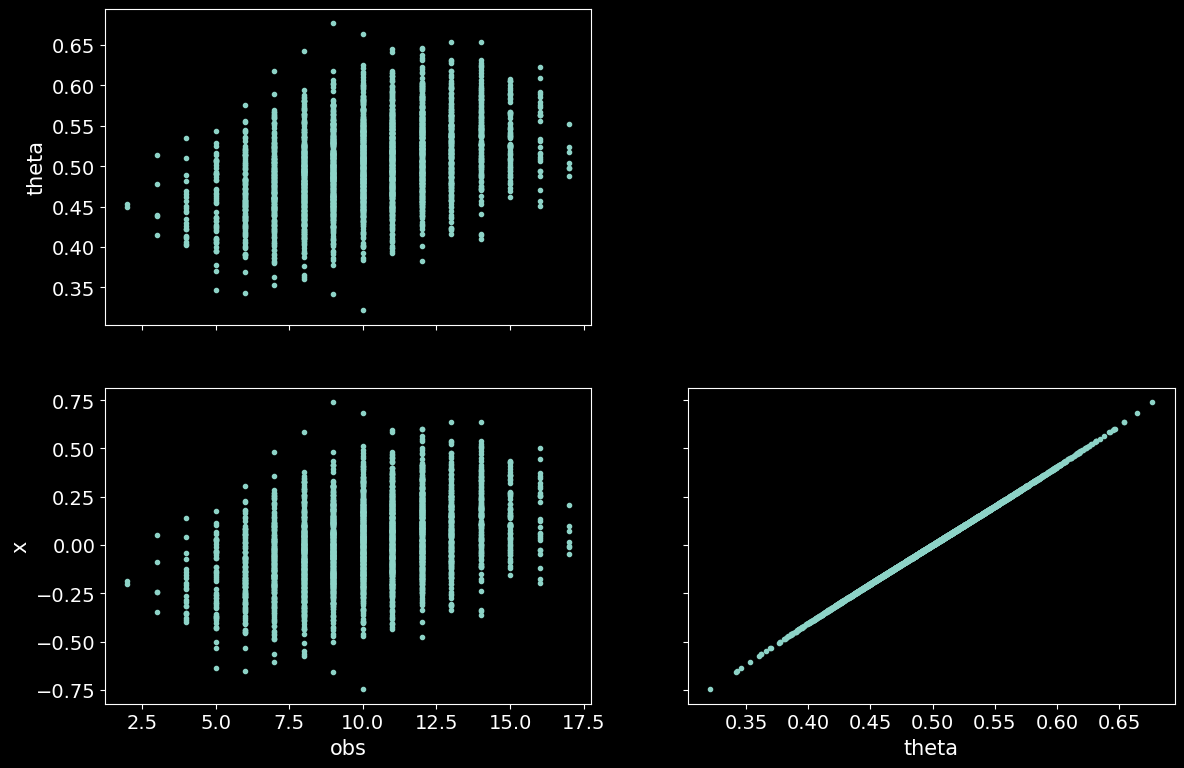

In [37]:
import arviz
arviz.plot_pair(pred); # not a posterior this time.

#### With another $(\mu, \sigma)$

In [38]:
# run the predictor, each run will yield a different result
rngkey, subkey = jax.random.split(rngkey)
pred = predictive(rngkey, -.3, 1./2, 20)       # what is the meaning of these prior parameters? Plot them. Homework!

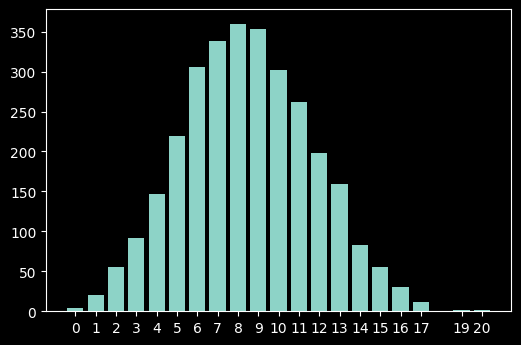

In [39]:
obs, count = np.unique(pred['obs'], return_counts=True)
plt.bar(obs, count)
plt.xticks(obs);

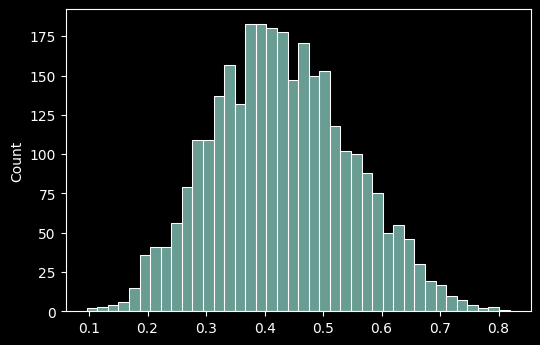

In [40]:
sns.histplot(pred['theta'], bins=40);

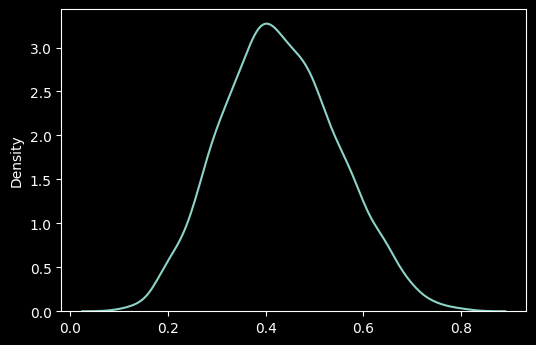

In [41]:
sns.kdeplot(pred['theta']);  # no useful plot

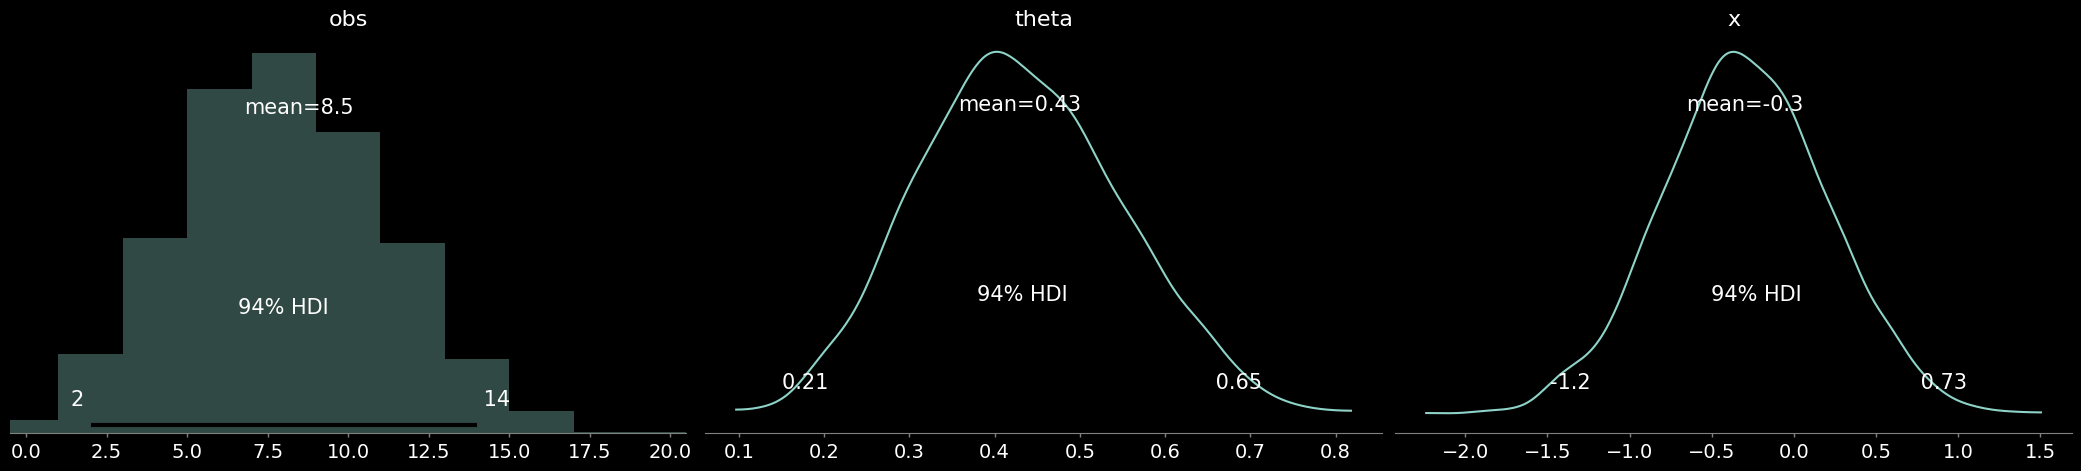

In [42]:
import arviz
arviz.plot_posterior(pred);  # look strange too

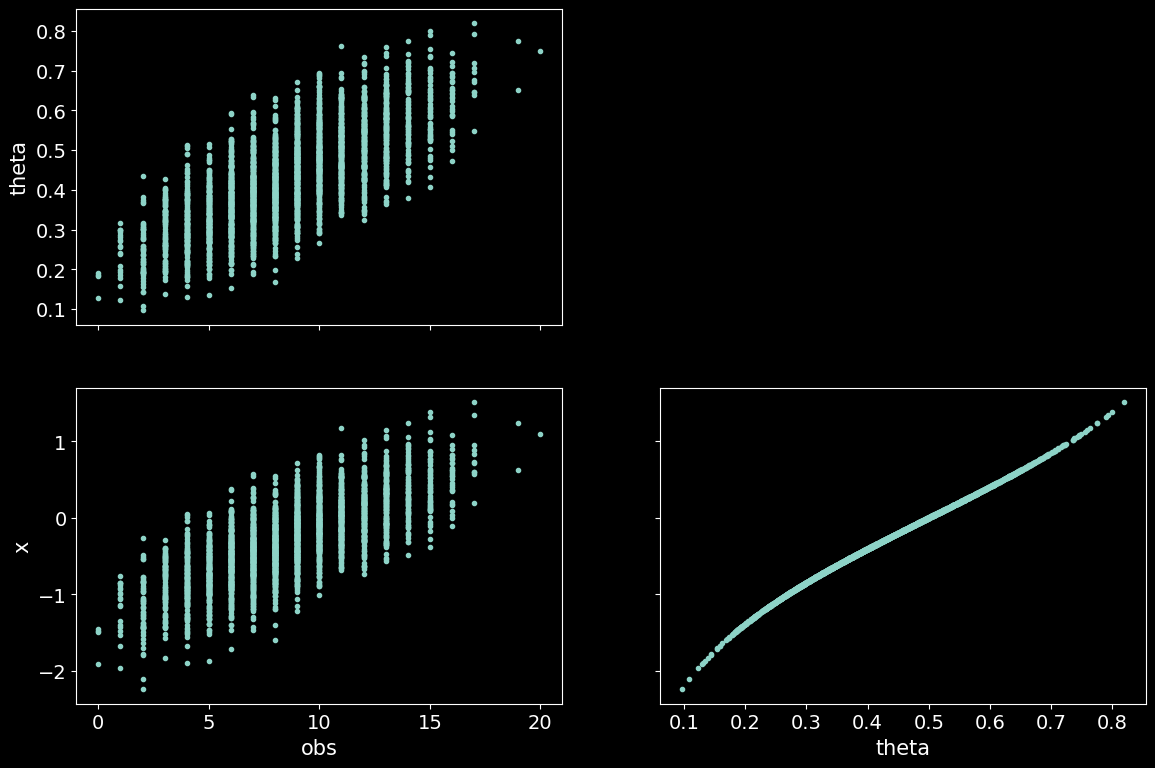

In [43]:
arviz.plot_pair(pred); # useful, note that it is not a posterior this time.

---

**Question**

1. Make a narrow shaped distribution of theta by controling $\mu$ and $\sigma$, and do predictive checks.
2. Try $mu=0$, $\sigma=3$, where the theta distribution looks bipartite.

# End.

In [62]:
!jupyter nbconvert Ch.6.Bernoulli_Logistic_Normal_numpyro.ipynb --to webpdf --HTMLExporter.theme=dark --allow-chromium-download

[NbConvertApp] Converting notebook Ch.6.Bernoulli_Logistic_Normal_numpyro.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1060762 bytes to Ch.6.Bernoulli_Logistic_Normal_numpyro.pdf
